In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame()

In [3]:
for root, dirs, files in os.walk("Sparky"):
    for dir in dirs:
        for file in os.listdir(os.path.join(root, dir)):
            if file.endswith(".csv"):
                csv_df = pd.read_csv(
                    os.path.join(root, dir, file), names=["event", "timestamp"]
                )
                # Filename: "S_results_2024061101.csv"
                csv_df["date_session"] = file.split("_")[2].split(".")[0]
                df = pd.concat([df, csv_df], ignore_index=True)

In [4]:
def parse_date_session(date_string):
    """Parse the date string and return a tuple of (datetime, session)"""
    year = int(date_string[:4])
    month = int(date_string[4:6])
    day = int(date_string[6:8])
    session = int(date_string[8:])
    return (datetime(year, month, day), session)

In [5]:
def analyze_and_group_trials(df):
    # Ensure the DataFrame is sorted by timestamp
    # df = df.sort_values("timestamp")

    # Initialize variables to track trials
    trial_data = []
    current_trial = {}

    for index, row in df.iterrows():
        event = row["event"]
        timestamp = row["timestamp"]

        if event == "prefix_off":
            # Start of a new trial
            if current_trial:
                # Add the previous trial to our list
                trial_data.append(current_trial)

            date_time, session = parse_date_session(row["date_session"])

            # Initialize a new trial
            current_trial = {
                "date_time": date_time,
                "session": session,
                "start_time": timestamp,
                "outcome": "failure",  # Default to failure unless we see a reward
            }
        elif event == "reward_on":
            current_trial["outcome"] = "success"

        # Update the end time of the current trial
        current_trial["end_time"] = timestamp

    # Add the last trial
    if current_trial:
        trial_data.append(current_trial)

    # Create a new DataFrame from the trial data
    trials_df = pd.DataFrame(trial_data)

    # Calculate trial duration
    trials_df["duration"] = trials_df["end_time"] - trials_df["start_time"]

    return trials_df

In [6]:
trials_df = analyze_and_group_trials(df)

In [7]:
trials_df = trials_df.sort_values(["date_time", "session", "start_time"]).reset_index(
    drop=True
)

In [8]:
def plot_success_rate_over_time(trials_df, window_size=50):
    """
    Plot success rate over time using a moving window average.

    :param trials_df: DataFrame containing trial data
    :param window_size: Size of the moving window for calculating average
    """
    # Convert outcome to binary (1 for success, 0 for failure)
    trials_df["success"] = (trials_df["outcome"] == "success").astype(int)

    # Calculate moving average of success rate
    rolling_success_rate = trials_df["success"].rolling(window=window_size).mean()

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the rolling average
    ax.plot(range(len(rolling_success_rate)), rolling_success_rate)

    # Set labels and title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Success Rate")
    ax.set_title(f"Success Rate Over Time (Moving Average, Window Size: {window_size})")

    # Add grid for better readability
    ax.grid(True, linestyle="--", alpha=0.7)

    # Set y-axis limits from 0 to 1
    ax.set_ylim(0, 1)

    # Add text annotations for start dates of each session
    session_starts = trials_df.groupby("date_time").first()
    for i, (date, row) in enumerate(session_starts.iterrows()):
        trial_num = trials_df[trials_df["date_time"] == date].index[0]
        ax.annotate(
            date.strftime("%Y-%m-%d"),
            (trial_num, 0.05),
            rotation=45,
            ha="right",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

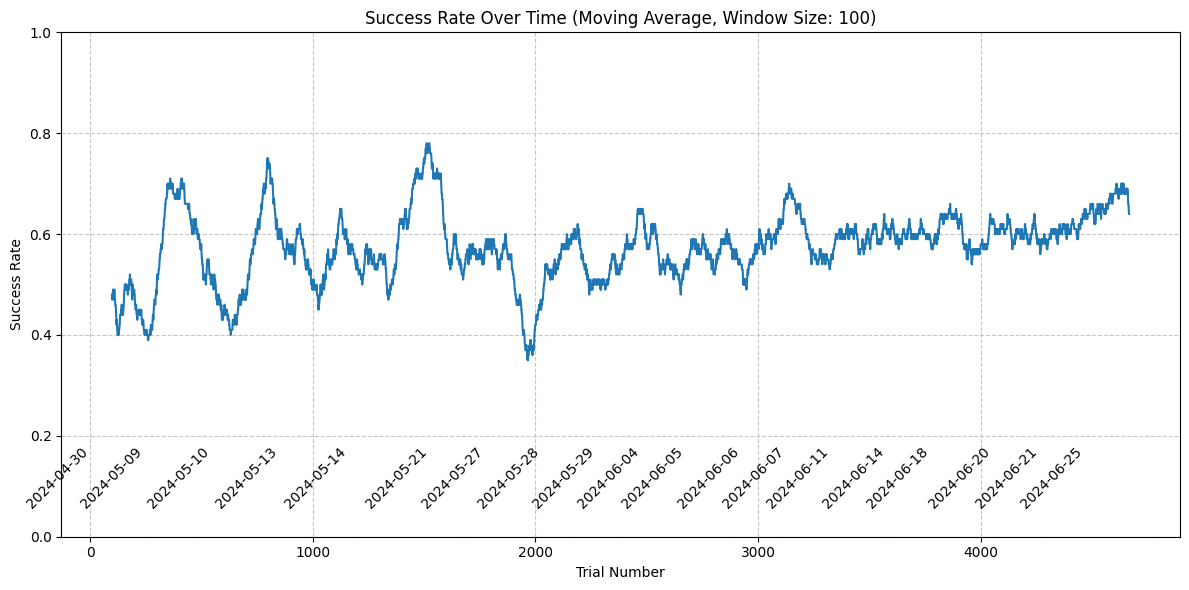

In [9]:
# Plot the success rate over time with a window size of 50 trials
plot_success_rate_over_time(trials_df, window_size=100)